In [1]:
import torch
from PIL import Image
import torchvision.transforms as T
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import numpy as np
from dinov2.hubconf import dinov2_vitg14

ModuleNotFoundError: No module named 'dinov2.hub'

In [24]:
model = torch.hub.load('dinov2', 'dinov2_vitg14', source='local', pretrained=False)
model.load_state_dict(torch.load('dinov2_vitg14_pretrain.pth'))

<All keys matched successfully>

In [19]:
def single_image_visualize(model, img, patch_h, patch_w):
    transform = T.Compose([
        T.Resize((patch_h * 14, patch_w * 14),T.InterpolationMode.BICUBIC),
        T.CenterCrop((patch_h * 14, patch_w * 14)),
        T.ToTensor(),
        T.Normalize(mean=[0.5], std=[0.5]),
        # T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    # print(transform)
    img = transform(img)[:3].unsqueeze(0)
    img = img.to('cuda')
    model = model.to('cuda')
    with torch.no_grad():
        features = model.forward_features(img)
    features = features['x_norm_patchtokens']
    features = features.reshape(1 * patch_h * patch_w, -1)
    pca = PCA(n_components=3)
    all_features =features.cpu()
    pca.fit(all_features)
    pca_features = pca.transform(all_features)
    pca_features = minmax_scale(pca_features) * 255
    plt.imshow(pca_features.reshape(patch_h, patch_w, 3).astype(np.uint8))

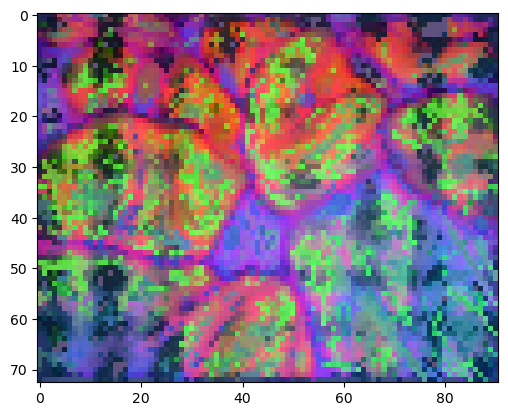

In [27]:
img = Image.open('0000000003.png').convert('RGB')
single_image_visualize(model,img,1024//14,1280//14)

In [34]:
def fg_single_image_visualize(model, img, patch_h, patch_w):
    transform = T.Compose([
        T.Resize((patch_h * 14, patch_w * 14),T.InterpolationMode.BICUBIC),
        T.CenterCrop((patch_h * 14, patch_w * 14)),
        T.ToTensor(),
        T.Normalize(mean=[0.5], std=[0.5]),
        # T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    # print(transform)
    img = transform(img)[:3].unsqueeze(0)
    img = img.to('cuda')
    model = model.to('cuda')
    with torch.no_grad():
        features = model.forward_features(img)
    features = features['x_norm_patchtokens']
    features = features.reshape(1 * patch_h * patch_w, -1)
    pca = PCA(n_components=1)
    all_features =features.cpu()
    pca.fit(all_features)
    pca_features = pca.transform(all_features)

    mask = pca_features > 0
    selected_indices = np.nonzero(mask)[0]
    # print(selected_indices.shape)
    selected_features = all_features[selected_indices]

    pca = PCA(n_components=3)
    pca.fit(selected_features)
    fg_features = pca.transform(selected_features)
    fg_features = minmax_scale(fg_features) * 255

    result = np.zeros((patch_h * patch_w, 3))
    result[selected_indices] = fg_features

    plt.imshow(result.reshape(patch_h, patch_w, 3).astype(np.uint8))

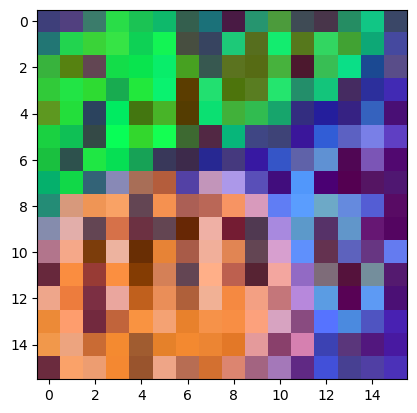

In [39]:
img = Image.open('0000000009.png').convert('RGB')
single_image_visualize(model,img,224//14,224//14)